In [53]:
#####################################################################################################
#####################################################################################################
####################### Import dependencies
#####################################################################################################
#####################################################################################################

import bovespa
import pandas as pd
import csv
import fnmatch
import re
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
from os import listdir, path
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from pandasql import sqldf

In [386]:
#####################################################################################################
#####################################################################################################
####################### Define constants and classes
#####################################################################################################
#####################################################################################################

# Constants
CONST_directory                            = "../data"
CONST_fdata_regex                          = "*.txt"
CONST_fcodes_not_regex                     = "\d\w|\d\d"
CONST_fcodes_regex                         = "^\w\w\w\w\d$"
CONST_ma_days                              = 21
CONST_sdv_times                            = 2
CONST_operation_start_days                 = 1
CONST_stop_buy                             = 0.1
CONST_comission                            = 5.0
CONST_amount                               = 5000.0
CONST_fig_x                                = 20
CONST_fig_y                                = 8

CONST_formula_label                        = "FORMULA"
CONST_date_label                           = "DATE"
CONST_ratio_label                          = "RATIO"
CONST_price_label                          = "PRICE"
CONST_cumulative_suffix_label              = "_CUMULATIVE"
CONST_buydate_label                        = "Buy Date:"
CONST_selldate_label                       = "Sell Date:"
CONST_file_label                           = "Arquivo:" 
CONST_stock1_label                         = "Stock 1:"
CONST_stock2_label                         = "Stock 2:"
CONST_operation_label                      = "Operation"
CONST_bbands_upper_label                   = "BBANDS_UPPER"
CONST_bbands_middleupper_label             = "BBANDS_MIDDLEUPPER"
CONST_bbands_base_label                    = "BBANDS_BASE"
CONST_bbands_middlelower_label             = "BBANDS_MIDDLELOWER"
CONST_bbands_lower_label                   = "BBANDS_LOWER"
CONST_bbands_trend_label                   = "BBANDS_TREND"
CONST_bbands_result_label                  = "BBANDS_TREND_PRICE"
CONST_bbands_cost_label                    = "BBANDS_COST"
CONST_revenue_prefix_label                 = "STOCK_REVENUE_"
CONST_cost_prefix_label                    = "STOCK_COST_"
CONST_result_prefix_label                  = "STOCK_RESULT_" 
CONST_gain_prefix_label                    = "STOCK_GAIN_"
CONST_stocks_prefix_label                  = "STOCK_QUANTITY_"
CONST_netincome_ratio_value_label          = "NETINCOME_VALUE_RATIO"
CONST_netincome_ratio_percent_label        = "NETINCOME_PERCENT_RATIO"

pysqldf = lambda q: sqldf(q, globals())

In [391]:
#####################################################################################################
#####################################################################################################
####################### Define constants and classes
#####################################################################################################
#####################################################################################################

# Classes
class Indicator:
    @classmethod
    def revenue(self, df, date_attr, price_attr, **kwargs):
        buy_date = (kwargs.get("buy_date") or df[date_attr][0])
        sell_date = (kwargs.get("sell_date") or df[date_attr][df[date_attr].size - 1])
        initial_amount = (kwargs.get("amount") or 10000.0)
        commision = (kwargs.get("commision") or 5.0)
        lot_size = (kwargs.get("lot_size") or 100)
        stop = (kwargs.get("stop") or None)
        start = (kwargs.get("start") or None)
        
        Revenue = pd.Series(None, index = df.index, name = (kwargs.get("revenue_name") or "REVENUE_NAME"))
        Result = pd.Series(None, index = df.index, name = (kwargs.get("result_name") or "RESULT_NAME"))
        Cost = pd.Series(None, index = df.index, name = (kwargs.get("cost_name") or "COST_NAME"))
        Stocks = pd.Series(0, index = df.index, name = (kwargs.get("stocks_name") or "STOCKS_NAME"))
        
        # Calculate first investment
        buy_line     = df[df[date_attr] == buy_date]
        lot_price    = (buy_line[price_attr]).item() * lot_size
        lot_qtd      = math.floor(initial_amount / lot_price)
        amount       = initial_amount - (lot_price * lot_qtd)
        idx          = buy_line.index.item()
        
        Stocks[idx]  = lot_qtd * lot_size
        Revenue[idx] = 0.0
        Cost[idx]    = -(comission + (lot_price * lot_qtd))
        Result[idx]  = amount + Cost[idx].item() + (lot_price * lot_qtd)
        
        for idx, value in df[np.logical_and(df[date_attr] > buy_date, df[date_attr] <= sell_date)].iterrows():
            previous_price     = (df.loc[idx-1][price_attr]).item()
            lot_price          = value[price_attr] * lot_size
            stocks             = Stocks[idx-1].item()
            Revenue[idx]       = (value[price_attr] - previous_price) * stocks
            result             = Result[idx-1].item() + Revenue[idx].item()            
            cost               = 0.0
            qtd_buy_sell       = 0
              
            # Buy more or close position
            if value[date_attr] == sell_date:
                cost += (stocks * value[price_attr]) - comission 
                stocks = 0
                lot_qtd = 0
                
            elif start and result >= (start * initial_amount) and result >= lot_price:
                qtd_buy_sell = math.floor(result / lot_price)
                amount       = result - (lot_price * qtd_buy_sell)
                lot_qtd      = lot_qtd + qtd_buy_sell
                cost        -= comission + (lot_price * qtd_buy_sell)
            
            Result[idx] = result + cost
            Cost[idx]   = cost
            Stocks[idx] = lot_size * lot_qtd
            
        return pd.concat([df[date_attr], Result, Revenue, Cost, Stocks], join='outer', axis=1)
    
    @classmethod
    def revenue_with_ratio(self, df, date_attr, stock1_price_attr, stock2_price_attr, bb_ratio_attr, bb_base_attr, bb_trend_attr, **kwargs):
        buy_date = (kwargs.get("buy_date") or df[date_attr][0])
        sell_date = (kwargs.get("sell_date") or df[date_attr][df[date_attr].size - 1])
        initial_amount = (kwargs.get("amount") or 10000.0)
        commision = (kwargs.get("commision") or 5.0)
        lot_size = (kwargs.get("lot_size") or 100)
        stop = (kwargs.get("stop") or None)
        start = (kwargs.get("start") or None)
        
        Revenue = pd.Series(None, index = df.index, name = (kwargs.get("revenue_name") or "REVENUE_NAME"))
        Result = pd.Series(None, index = df.index, name = (kwargs.get("result_name") or "RESULT_NAME"))
        Cost = pd.Series(None, index = df.index, name = (kwargs.get("cost_name") or "COST_NAME"))
        Stocks = pd.Series(0, index = df.index, name = (kwargs.get("stocks_name") or "STOCKS_NAME"))
        
        # It defines the first buy of stock for net income calculation
        buy_line  = df[df[date_attr] == buy_date]
        
        if (buy_line[bb_base_attr]).item() and ((buy_line[bb_ratio_attr]).item() > (buy_line[bb_base_attr]).item()):
            trend = 1
        else:
            trend = -1
        
        price_attr = stock1_price_attr if trend == -1 else stock2_price_attr
        
        # Calculate first investment
        lot_price    = (buy_line[price_attr]).item() * lot_size
        lot_qtd      = math.floor(initial_amount / lot_price)
        amount       = initial_amount - (lot_price * lot_qtd)
        idx          = buy_line.index.item()
        
        Stocks[idx]  = lot_qtd * lot_size
        Revenue[idx] = 0.0
        Cost[idx]    = -(comission + (lot_price * lot_qtd))
        Result[idx]  = amount + Cost[idx].item() + (lot_price * lot_qtd)
        
        for idx, value in df[np.logical_and(df[date_attr] > buy_date, df[date_attr] <= sell_date)].iterrows():
            previous_price     = (df.loc[idx-1][price_attr]).item()
            lot_price          = value[price_attr] * lot_size
            stocks             = Stocks[idx-1].item()
            Revenue[idx]       = (value[price_attr] - previous_price) * stocks
            result             = Result[idx-1].item() + Revenue[idx].item()            
            cost               = 0.0
            qtd_buy_sell       = 0
              
            print(idx, (value[bb_trend_attr] == 1 and trend == -1), (value[bb_trend_attr] == -1 and trend == 1), (start and (result >= (start * initial_amount))), (start and (result >= lot_price)), result, lot_price)
            # Change, buy more or close position
            if value[date_attr] == sell_date:
                cost += (stocks * value[price_attr]) - comission 
                stocks = 0
                lot_qtd = 0

            elif (value[bb_trend_attr] == 1 and trend == -1) or (value[bb_trend_attr] == -1 and trend == 1):
                trend = 1 if trend == -1 else -1
                price_attr = stock2_price_attr if trend == 1 else stock1_price_attr

                # Sell
                cost   += (lot_price * lot_qtd) - commision
                result += cost
                stocks  = 0
                lot_qtd = 0

                # Buy
                lot_price = value[price_attr] * lot_size
                lot_qtd   = math.floor(result / lot_price)
                amount    = result - (lot_price * lot_qtd)
                prev_cost = cost
                cost      -= comission + (lot_price * lot_qtd)
                result    = amount - prev_cost + (lot_price * lot_qtd)
                
            elif start and result >= (start * initial_amount) and result >= lot_price:
                qtd_buy_sell = math.floor(result / lot_price)
                amount       = result - (lot_price * qtd_buy_sell)
                lot_qtd      = lot_qtd + qtd_buy_sell
                cost        -= comission + (lot_price * qtd_buy_sell)
            
            Result[idx] = result + cost
            Cost[idx]   = cost
            Stocks[idx] = lot_size * lot_qtd

        return pd.concat([df[date_attr], Result, Revenue, Cost, Stocks], join='outer', axis=1)
            
    @classmethod
    def bbands(self, df, date_attr, price_attr, n, nstd, nresult, **kwargs):
        buy_date = (kwargs.get("buy_date") or df[date_attr][0])
        sell_date = (kwargs.get("sell_date") or df[date_attr][df[date_attr].size - 1])
        comission = (kwargs.get("comission") or 5.0)
        
        MA = pd.Series(df[price_attr].rolling(window=n).mean())
        MSD = pd.Series(df[price_attr].rolling(window=n).std())
        
        Base = pd.Series(MA, name = (kwargs.get("base_name") or "BASE"))
        Middle_upper = pd.Series(MA + MSD * nstd/2, name = (kwargs.get("middle_upper_name") or "MIDDLE_UPPER"))
        Middle_lower = pd.Series(MA - MSD * nstd/2, name = (kwargs.get("middle_lower_name") or "MIDDLE_LOWER"))
        Upper = pd.Series(MA + MSD * nstd, name = (kwargs.get("upper_name") or "UPPER"))
        Lower = pd.Series(MA - MSD * nstd, name = (kwargs.get("lower_name") or "LOWER"))        
        
        Cost = pd.Series(0, index = Lower.index, name = (kwargs.get("cost_name") or "COST"))
        Trend = pd.Series(0, index = Lower.index, name = (kwargs.get("trend_name") or "TREND"))
        Result = pd.Series(None, index = Lower.index, name = (kwargs.get("result_name") or "RESULT"))
        
        last_result = None
        last_idx = 0
        last_trend = None
        
        for idx, value in df[np.logical_and(df[date_attr] > buy_date, df[date_attr] <= sell_date)].iterrows():
            if idx >= n:
                # Trend/Result calculation
                if ((last_trend != 1) and 
                        ((df[price_attr][idx] > Upper[idx]) or 
                        ((last_trend != 1) and ((idx - last_idx) >= nresult) and (df[price_attr][idx] > Middle_upper[idx])) or
                        ((last_trend != 1) and ((idx - last_idx) >= 2*nresult) and (df[price_attr][idx] > Base[idx])))):
                    Trend[idx] = 1
                elif ((last_trend != -1) and 
                        ((df[price_attr][idx] < Lower[idx]) or 
                        ((last_trend != -1) and ((idx - last_idx) >= nresult) and (df[price_attr][idx] < Middle_lower[idx])) or
                        ((last_trend != -1) and ((idx - last_idx) >= 2*nresult) and (df[price_attr][idx] < Base[idx])))):
                    Trend[idx] = -1                                   
                    
                # Lower/Upper adjust based on trend    
                if (Trend[idx] == 1) and (Lower[idx] < Lower[idx-1]):
                    Lower[idx] = Lower[idx-1]
                elif (Trend[idx] == -1) and (Upper[idx] > Upper[idx-1]):
                    Upper[idx] = Upper[idx-1]
                
                # Update result
                if (Trend[idx] != 0):
                    Result[idx] = df[price_attr][idx]
                    Cost[idx] = -2 * comission 
                    last_result = Result[idx]
                    last_idx = idx
                    last_trend = Trend[idx]                    
                    
        return pd.concat([df[date_attr], Upper, Middle_upper, Base, Middle_lower, Lower, Result, Trend, Cost], join='outer', axis=1)

class Parser:
    def __init__(self, inpt, output=None):
        self.input = inpt
        self.output = output

    @classmethod
    def convert_record_to_dict(self, query):
        for rec in query:
            yield rec.info

    def get_query(self):
        bf = bovespa.File(self.input)
        return bf.query()

    def get_dataframe(self):
        return pd.DataFrame(self.convert_record_to_dict(self.get_query()))
    
class Select:
    def __init__(self, option=None, dropdown=None):
        self.option = option
        self.dropdown = dropdown
        
    def get_dropdown(self, options, description="Option:"):
        if not self.dropdown:
            w = widgets.Dropdown(options=options,description=description,value=options[0])
            w.observe(self.on_change)
            self.dropdown = w
            self.option = w.value
        
        return self.dropdown
    
    def on_change(self, change):      
        if change.name == "value" and change.type == "change":
            self.option = change.new    
            
class Reader(Select):
    @classmethod
    def get_files(self, where, regex):
        return sorted([name for name in listdir(where) if re.compile(fnmatch.translate(regex), re.IGNORECASE).match(name)])

In [4]:
#####################################################################################################
#####################################################################################################
####################### Select Bovespa file
#####################################################################################################
#####################################################################################################

file = Select()
display(file.get_dropdown(Reader.get_files(CONST_directory, CONST_fdata_regex), CONST_file_label))

Dropdown(description='Arquivo:', options=('COTAHIST_A05-11.TXT', 'COTAHIST_A15-18.TXT', 'COTAHIST_A2005.TXT', …

In [5]:
#####################################################################################################
#####################################################################################################
####################### Parse Bovespa file
#####################################################################################################
#####################################################################################################

p = Parser(path.join(CONST_directory, file.option))
d = p.get_dataframe()

codes = d.CODNEG
options = codes[
    np.logical_and(
        ~codes.str.contains(CONST_fcodes_not_regex),
        codes.str.contains(CONST_fcodes_regex)
    )].sort_values().unique()

stock1 = Select()
stock2 = Select()

display(stock1.get_dropdown(options, CONST_stock1_label))
display(stock2.get_dropdown(options, CONST_stock2_label))

Dropdown(description='Stock 1:', options=('AALR3', 'ABCB2', 'ABCB4', 'ABEV3', 'ABRE3', 'ADHM3', 'AELP3', 'AFLT…

Dropdown(description='Stock 2:', options=('AALR3', 'ABCB2', 'ABCB4', 'ABEV3', 'ABRE3', 'ADHM3', 'AELP3', 'AFLT…

In [6]:
#####################################################################################################
#####################################################################################################
####################### Select Buydate and Selldate
#####################################################################################################
#####################################################################################################

d_stock1 = d[codes == stock1.option]
d_stock1.index = range(len(d_stock1))
d_stock2 = d[codes == stock2.option]
d_stock2.index = range(len(d_stock2))

buy_date = Select()
sell_date = Select()

display(buy_date.get_dropdown(d_stock1.DATPRG, CONST_buydate_label))
display(sell_date.get_dropdown(d_stock1.DATPRG, CONST_selldate_label))

Dropdown(description='Buy Date:', options=(datetime.date(2015, 1, 2), datetime.date(2015, 1, 5), datetime.date…

Dropdown(description='Sell Date:', options=(datetime.date(2015, 1, 2), datetime.date(2015, 1, 5), datetime.dat…

In [392]:
#####################################################################################################
#####################################################################################################
####################### Generate Dataframe
#####################################################################################################
#####################################################################################################

CONST_formula = f"{stock1.option}/{stock2.option}"

stocks = pd.DataFrame(data={
    CONST_date_label: d_stock1.DATPRG,
    CONST_formula_label: CONST_formula,
    CONST_ratio_label: d_stock1.PREULT/d_stock2.PREULT,
    stock1.option: d_stock1.PREULT,
    stock2.option: d_stock2.PREULT    
})

bbands = Indicator.bbands(
    stocks,
    CONST_date_label,
    CONST_ratio_label, 
    CONST_ma_days, 
    CONST_sdv_times, 
    CONST_operation_start_days,
    comission = CONST_comission,
    upper_name = CONST_bbands_upper_label,
    middle_upper_name = CONST_bbands_middleupper_label,
    base_name = CONST_bbands_base_label,
    middle_lower_name = CONST_bbands_middlelower_label,
    lower_name = CONST_bbands_lower_label,
    trend_name = CONST_bbands_trend_label,
    result_name = CONST_bbands_result_label,
    cost_name = CONST_bbands_cost_label
)

result_start_stock1 = Indicator.revenue(
    stocks, 
    CONST_date_label,    
    stock1.option,
    amount = CONST_amount,
    comission = CONST_comission,
    buy_date = buy_date.option, 
    sell_date = sell_date.option,
    start = CONST_stop_buy,
    revenue_name = (CONST_revenue_prefix_label + "START_" + stock1.option),
    cost_name = (CONST_cost_prefix_label + "START_" + stock1.option), 
    result_name = (CONST_result_prefix_label + "START_" + stock1.option), 
    stocks_name = (CONST_stocks_prefix_label + "START_" + stock1.option)
)

result_stock1 = Indicator.revenue(
    stocks, 
    CONST_date_label,    
    stock1.option,
    amount = CONST_amount,
    comission = CONST_comission,
    buy_date = buy_date.option, 
    sell_date = sell_date.option,
    revenue_name = (CONST_revenue_prefix_label + stock1.option),
    cost_name = (CONST_cost_prefix_label + stock1.option), 
    result_name = (CONST_result_prefix_label + stock1.option), 
    stocks_name = (CONST_stocks_prefix_label + stock1.option)
)

result_start_stock2 = Indicator.revenue(
    stocks, 
    CONST_date_label,
    stock2.option, 
    amount = CONST_amount,
    comission = CONST_comission,    
    buy_date = buy_date.option,
    sell_date = sell_date.option,
    start = CONST_stop_buy,
    revenue_name = (CONST_revenue_prefix_label + "START_" + stock2.option), 
    cost_name = (CONST_cost_prefix_label + "START_" + stock2.option), 
    result_name = (CONST_result_prefix_label + "START_" + stock2.option), 
    stocks_name = (CONST_stocks_prefix_label + "START_" + stock2.option)
)

result_stock2 = Indicator.revenue(
    stocks, 
    CONST_date_label,
    stock2.option, 
    amount = CONST_amount,
    comission = CONST_comission,
    buy_date = buy_date.option,
    sell_date = sell_date.option,
    revenue_name = (CONST_revenue_prefix_label + stock2.option), 
    cost_name = (CONST_cost_prefix_label + stock2.option), 
    result_name = (CONST_result_prefix_label + stock2.option), 
    stocks_name = (CONST_stocks_prefix_label + stock2.option)
)

df = pd.merge(stocks, bbands, on=CONST_date_label)
df = pd.merge(df, result_stock1, on=CONST_date_label)
df = pd.merge(df, result_start_stock1, on=CONST_date_label)
df = pd.merge(df, result_stock2, on=CONST_date_label)
df = pd.merge(df, result_start_stock2, on=CONST_date_label)

# result_ratio = Indicator.revenue_with_ratio(
#     df,
#     CONST_date_label,
#     stock1.option, 
#     stock2.option, 
#     CONST_ratio_label, 
#     CONST_bbands_base_label, 
#     CONST_bbands_trend_label,
#     amount = CONST_amount,
#     comission = CONST_comission,    
#     buy_date = buy_date.option, 
#     sell_date = sell_date.option, 
#     revenue_name = (CONST_revenue_prefix_label + "RATIO"),
#     cost_name = (CONST_cost_prefix_label + "RATIO"), 
#     result_name = (CONST_result_prefix_label + "RATIO"),
#     stocks_name = (CONST_stocks_prefix_label + "RATIO")
# )

result_start_ratio = Indicator.revenue_with_ratio(
    df,
    CONST_date_label,
    stock1.option, 
    stock2.option, 
    CONST_ratio_label, 
    CONST_bbands_base_label,
    CONST_bbands_trend_label,
    amount = CONST_amount,
    comission = CONST_comission,
    start = CONST_stop_buy,
    buy_date = buy_date.option, 
    sell_date = sell_date.option, 
    revenue_name = (CONST_revenue_prefix_label + "START_RATIO"),
    cost_name = (CONST_cost_prefix_label + "START_RATIO"), 
    result_name = (CONST_result_prefix_label + "START_RATIO"),
    stocks_name = (CONST_stocks_prefix_label + "START_RATIO")
)

df = pd.merge(df, result_ratio, on=CONST_date_label)
df = pd.merge(df, result_start_ratio, on=CONST_date_label)

# Add cumulative columns
# labels = [CONST_result_stock1, CONST_result_stock2, CONST_result_ratio]
# labels_cum = [(x + CONST_cumulative_suffix_label) for x in labels]
# for l in zip(labels_cum, labels):
#     netincome[l[0]] = netincome[l[1]].cumsum()

2 False False True False 550.0000000000003 833.0
3 False False True False 720.0000000000002 867.0
4 False False True True 975.0000000000001 918.0
5 False False False False 184.0000000000005 940.0
6 False False False False -109.9999999999996 891.0
7 False False False False -55.99999999999969 900.0
8 False False False False -211.99999999999957 874.0
9 False False False False 148.0000000000002 934.0
10 False False False False 208.0 944.0
11 False False False False 58.0 919.0
12 False False False False 136.00000000000045 932.0
13 False False False False 436.00000000000045 982.0
14 False False True False 694.0000000000002 1025.0
15 False False True False 544.0000000000002 1000.0
16 False False False False 490.00000000000034 991.0
17 False False True False 646.0000000000002 1017.0
18 False False False False -38.000000000000114 902.9999999999999
19 False False False False -205.99999999999972 875.0
20 False False False False -547.9999999999999 818.0
21 False False False False -259.999999999999

239 False False False False 497.00000000000114 702.0
240 False False False False 345.0000000000012 664.0
241 False False False False 405.00000000000136 679.0
242 False False False False 461.00000000000125 693.0
243 False False False False 369.0000000000014 670.0
244 False False False False 365.0000000000015 669.0
245 False False False False 369.00000000000136 670.0
246 False False False False 437.00000000000136 687.0
247 False False False False 361.0000000000012 668.0
248 False False False False 249.00000000000145 640.0
249 False False False False 193.00000000000122 626.0
250 False False False False 197.00000000000114 627.0
251 True False False False 125.00000000000125 609.0
252 False False False False 103.00000000000134 700.0
253 False True False False 43.00000000000128 680.0
254 False False True True 618.0000000000016 569.0
255 False False False False -163.99999999999858 517.0
256 False False False False -311.99999999999864 480.0
257 False False False False -367.9999999999985 466.0
2

605 False False True False 557.0000000000024 1294.0
606 False False False False 429.0000000000023 1262.0
607 False False False False 293.00000000000233 1228.0
608 False False False False 297.0000000000023 1229.0
609 False False False False 125.00000000000239 1186.0
610 False False False False 37.00000000000284 1164.0
611 False False False False 197.00000000000227 1204.0
612 False False False False 153.0000000000025 1193.0
613 True False False False 289.00000000000244 1227.0
614 False False True False 1230.0000000000027 1299.0
615 False False True False 1197.000000000003 1288.0
616 False False True False 1236.0000000000027 1301.0
617 False False True False 1293.0000000000025 1320.0
618 False True True False 1317.0000000000025 1328.0
619 False False False False 375.00000000000284 1243.0
620 True False False False 287.0000000000033 1221.0
621 False False True False 1204.0000000000034 1293.0
622 False False True False 1129.0000000000034 1268.0
623 False False True False 1135.0000000000032 

804 False False False False 263.00000000000523 2115.0
805 False False False False 354.00000000000705 2128.0
806 False False False False -170.99999999999295 2053.0
807 False False False False 438.00000000000523 2140.0
808 False False True False 718.0000000000067 2180.0
809 False False True False 634.000000000006 2168.0
810 False False False False 298.00000000000574 2120.0
811 False False False False -107.99999999999307 2062.0
812 False False False False 179.00000000000705 2103.0
813 False False True False 718.0000000000067 2180.0
814 True False True False 998.0000000000057 2220.0
815 False False True False 1942.0000000000066 2443.0
816 False False True False 1894.0000000000077 2435.0
817 False False True False 1846.0000000000066 2427.0
818 False False True False 1384.0000000000068 2350.0
819 False False True False 1954.0000000000064 2445.0
820 False False True False 1996.0000000000066 2452.0


In [394]:
sql = """
select 

BBANDS_TREND as T, 

PETR3 as P3, 
PETR4 as P4, 

STOCK_RESULT_START_PETR3 as ResSP3, 
STOCK_REVENUE_START_PETR3 as RevSP3, 
STOCK_COST_START_PETR3 as CosSP3, 
STOCK_QUANTITY_START_PETR3 as StksSP3, 

STOCK_RESULT_START_PETR4 as ResSP4, 
STOCK_REVENUE_START_PETR4 as RevSP4, 
STOCK_COST_START_PETR4 as CosSP4, 
STOCK_QUANTITY_START_PETR4 as StksSP4,

STOCK_RESULT_START_RATIO as ResSR,
STOCK_REVENUE_START_RATIO as RevSR,
STOCK_COST_START_RATIO as CosSR,
STOCK_QUANTITY_START_RATIO as StksSR

from df
"""

r = pysqldf(sql)
with pd.option_context('display.max_rows', 1000):
    display(r)
    
print(r['RevSP3'].cumsum(), r['RevSP4'].cumsum(), r['RevSR'].cumsum())
# print(df.columns)
# display(result_stock1)
# display(result_start_stock1)
# display(result_stock2)
# display(result_start_stock2)
# display(df)

,T,P3,P4,ResSP3,RevSP3,CosSP3,StksSP3,ResSP4,RevSP4,CosSP4,StksSP4,ResSR,RevSR,CosSR,StksSR
0,0,9.00,9.36,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0
1,0,8.27,8.61,33.0,0.0,-4967.0,600,690.0,0.0,-4310.0,500,6.900000e+02,0.0,-4310.0,500
2,0,8.06,8.33,-93.0,-126.0,0.0,600,550.0,-140.0,0.0,500,5.500000e+02,-140.0,0.0,500
3,0,8.45,8.67,141.0,234.0,0.0,600,720.0,170.0,0.0,500,7.200000e+02,170.0,0.0,500
4,0,9.02,9.18,483.0,342.0,0.0,600,52.0,255.0,-923.0,600,5.200000e+01,255.0,-923.0,600
5,0,9.29,9.40,645.0,162.0,0.0,600,184.0,132.0,0.0,600,1.840000e+02,132.0,0.0,600
6,0,8.77,8.91,333.0,-312.0,0.0,600,-110.0,-294.0,0.0,600,-1.100000e+02,-294.0,0.0,600
7,0,8.83,9.00,369.0,36.0,0.0,600,-56.0,54.0,0.0,600,-5.600000e+01,54.0,0.0,600
8,0,8.50,8.74,171.0,-198.0,0.0,600,-212.0,-156.0,0.0,600,-2.120000e+02,-156.0,0.0,600
9,0,9.25,9.34,621.0,450.0,0.0,600,148.0,360.0,0.0,600,1.480000e+02,360.0,0.0,600


0          NaN
1          0.0
2       -126.0
3        108.0
4        450.0
5        612.0
6        300.0
7        336.0
8        138.0
9        588.0
10       576.0
11       366.0
12       372.0
13       714.0
14       924.0
15       750.0
16       762.0
17       822.0
18       216.0
19       120.0
20      -138.0
21       180.0
22       912.0
23       978.0
24       810.0
25       369.0
26       488.0
27       229.0
28       243.0
29       607.0
        ...   
791    14921.0
792    13751.0
793    14201.0
794    15506.0
795    15311.0
796    15431.0
797    15731.0
798    14846.0
799    14411.0
800    14906.0
801    13976.0
802    14066.0
803    13946.0
804    14876.0
805    15236.0
806    14216.0
807    15566.0
808    16391.0
809    16451.0
810    15461.0
811    14201.0
812    14831.0
813    15971.0
814    16421.0
815    16511.0
816    16391.0
817    16271.0
818    15116.0
819    16541.0
820    16646.0
Name: RevSP3, Length: 821, dtype: float64 0          NaN
1          0.0
2       -140.

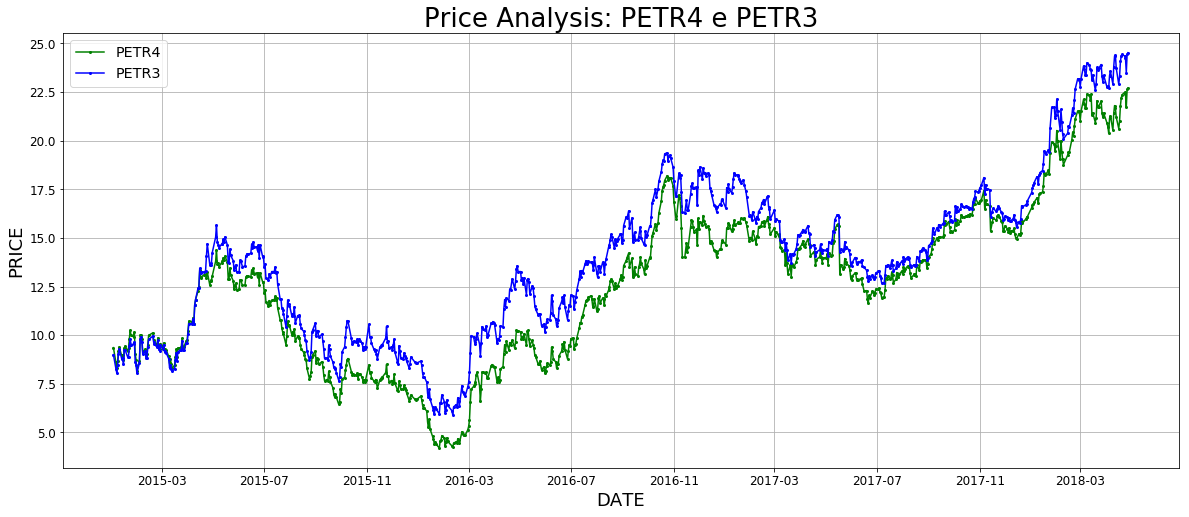

In [295]:
#####################################################################################################
#####################################################################################################
####################### Price Analysis
#####################################################################################################
#####################################################################################################

fig, ax = plt.subplots()
ax.plot(stocks[CONST_date_label], stocks[stock1.option], marker='o', markersize=2, color='green')
ax.plot(stocks[CONST_date_label], stocks[stock2.option], marker='o', markersize=2, color='blue')

fig.set_size_inches(CONST_fig_x, CONST_fig_y)

ax.set_xlabel(CONST_date_label, size=18)
ax.set_ylabel(CONST_price_label, size=18)
ax.set_autoscale_on(True)
ax.set_title("Price Analysis: " + stock1.option + " e " + stock2.option, size=26)
ax.tick_params(labelsize="large")
ax.grid()
ax.legend(fontsize="x-large")

# fig.savefig("test.png")
plt.show()

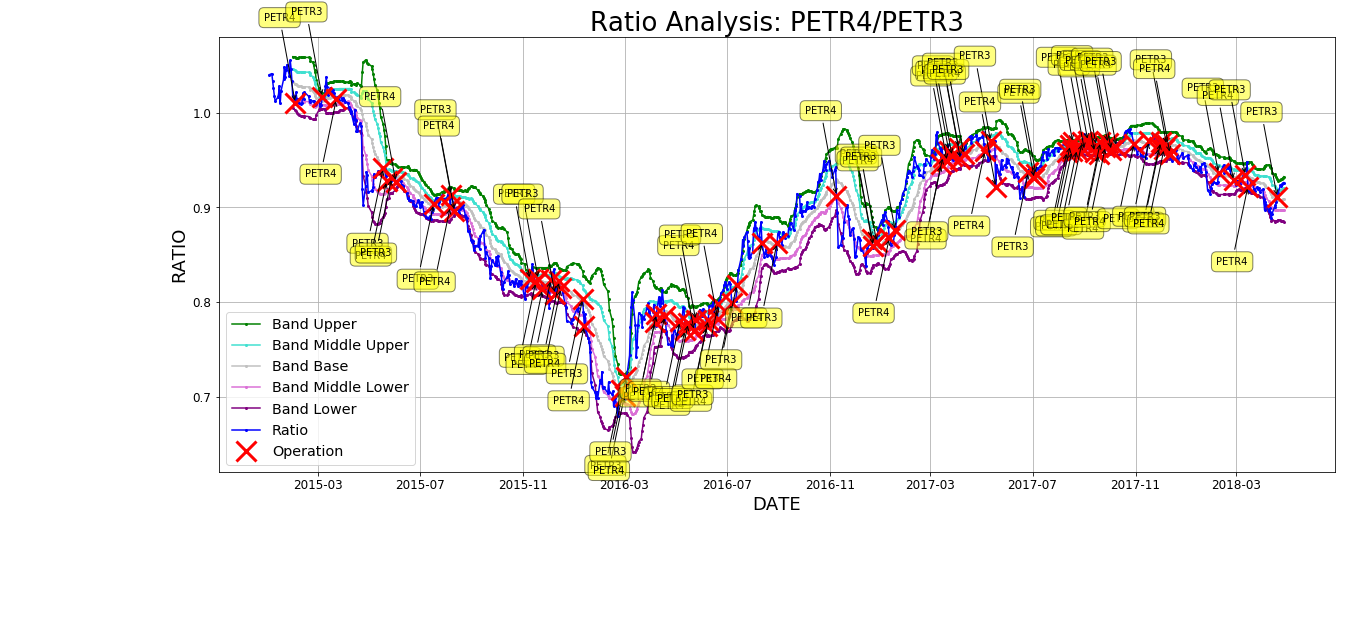

In [9]:
#####################################################################################################
#####################################################################################################
####################### Ratio Analysis
#####################################################################################################
#####################################################################################################

fig, ax = plt.subplots()

ax.plot(bbands[CONST_date_label], bbands[CONST_bbands_upper_label], marker='o', markersize=2, color='green', label='Band Upper')
ax.plot(bbands[CONST_date_label], bbands[CONST_bbands_middleupper_label], marker='o', markersize=2, ls='solid', color='turquoise', label='Band Middle Upper')
ax.plot(bbands[CONST_date_label], bbands[CONST_bbands_base_label], marker='o', markersize=2, color='silver', label='Band Base')
ax.plot(bbands[CONST_date_label], bbands[CONST_bbands_middlelower_label], marker='o', markersize=2, ls='solid', color='orchid', label='Band Middle Lower')
ax.plot(bbands[CONST_date_label], bbands[CONST_bbands_lower_label], marker='o', markersize=2, color='purple', label='Band Lower')
ax.plot(stocks[CONST_date_label], stocks[CONST_ratio_label], marker='o', markersize=2, color='blue', label='Ratio')
ax.plot(bbands[CONST_date_label], bbands[CONST_bbands_result_label], marker='x', ls='None', ms=20, mec='r', mew=3, color='r', label=CONST_operation_label)

fig.set_size_inches(CONST_fig_x, CONST_fig_y)

def get_label(trend, y, stock1, stock2):
        opr = stock1 if trend == -1 else stock2
        return opr #+ "\n" + str(round(label, 2))
    
def get_position(x, y):
    return 0, ((x.toordinal() % 2) * 2 - 1) * 80

for rect in ax.lines:
    if rect.get_label() == CONST_operation_label:
        data = rect.get_data()
        xdata = data[0]
        ydata = data[1]
        
        for x, y in zip(xdata, ydata):
            if y:
                plt.annotate(
                    get_label((bbands[bbands[CONST_date_label] == x][CONST_bbands_trend_label]).item(), y, stock1.option, stock2.option),
                    xy=(x, y), 
                    xytext= get_position(x, y),
                    textcoords='offset points', 
                    ha='right', 
                    va='bottom',
                    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                    arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

ax.set_xlabel(CONST_date_label, size=18)
ax.set_ylabel(CONST_ratio_label, size=18)
ax.set_autoscale_on(True)
ax.set_title("Ratio Analysis: " + CONST_formula, size=26)
ax.tick_params(labelsize="large")
ax.grid()
ax.legend(fontsize='x-large')

# fig.savefig("test.png")
plt.show()

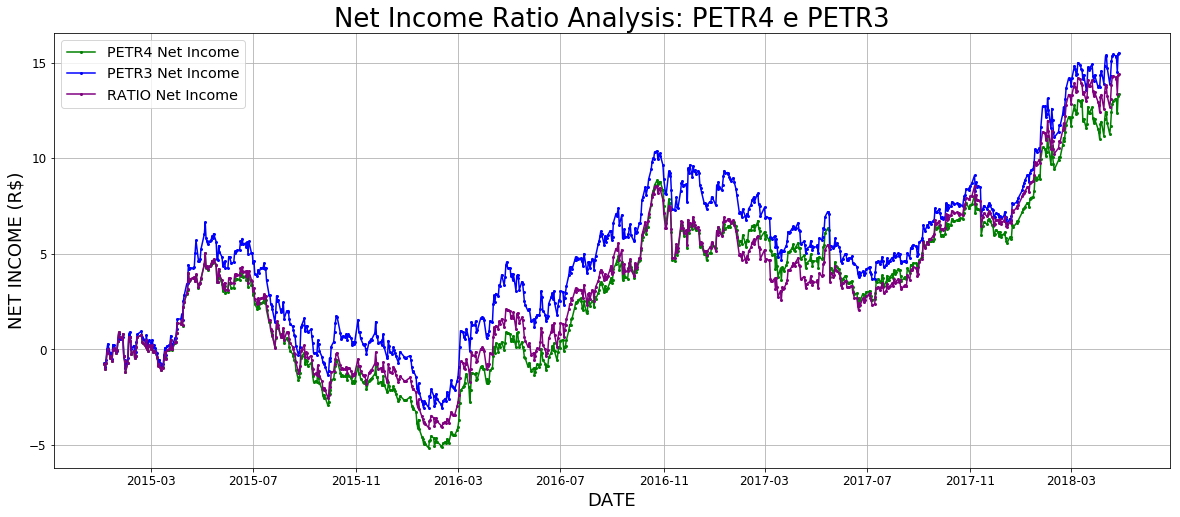

In [10]:
#####################################################################################################
#####################################################################################################
####################### Net Income Ratio Analysis
#####################################################################################################
#####################################################################################################

fig, ax = plt.subplots()
ax.plot(netincome[CONST_date_label], netincome[(netincome_stock1_value_name + CONST_cumulative_suffix_label)], marker='o', markersize=2, color='green', label=(stock1.option + ' Net Income'))
ax.plot(netincome[CONST_date_label], netincome[(netincome_stock2_value_name + CONST_cumulative_suffix_label)], marker='o', markersize=2, color='blue', label=(stock2.option + ' Net Income'))
ax.plot(netincome[CONST_date_label], netincome[(CONST_netincome_ratio_value_label + CONST_cumulative_suffix_label)], marker='o', markersize=2, color='purple', label=(CONST_ratio_label + ' Net Income'))

fig.set_size_inches(CONST_fig_x, CONST_fig_y)

ax.set_xlabel(CONST_date_label, size=18)
ax.set_ylabel("NET INCOME (R$)", size=18)
ax.set_autoscale_on(True)
ax.set_title("Net Income Ratio Analysis: " + stock1.option + " e " + stock2.option, size=26)
ax.tick_params(labelsize="large")
ax.grid()
ax.legend(fontsize='x-large')

# fig.savefig("test.png")
plt.show()

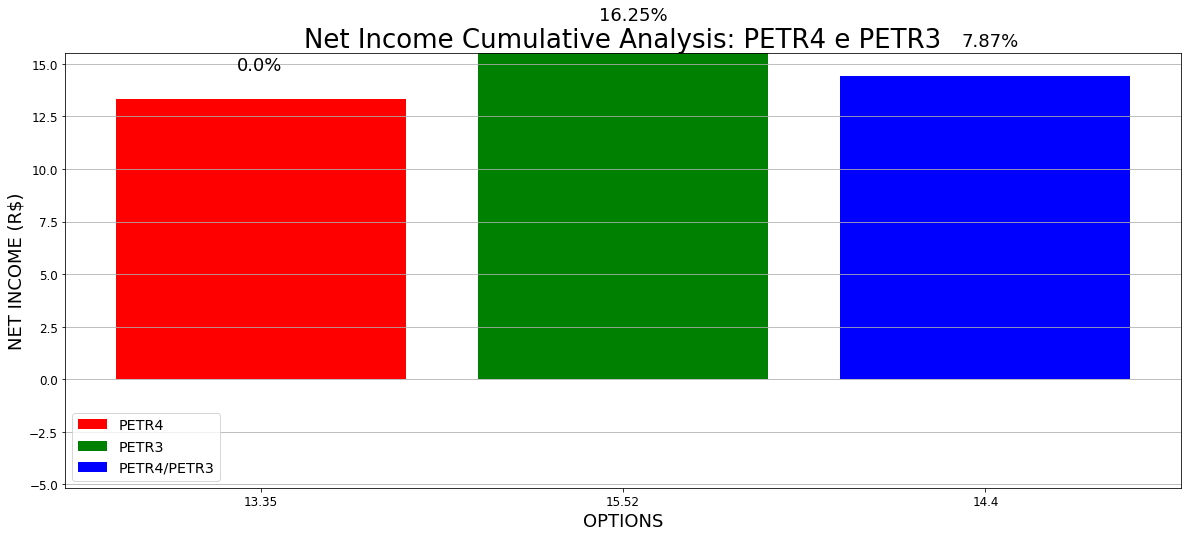

In [11]:
#####################################################################################################
#####################################################################################################
####################### Net Income Cumulative Analysis
#####################################################################################################
#####################################################################################################

fig, ax = plt.subplots()

ind = np.arange(3)
step = ind[1] - ind[0]

values = [
    netincome[np.logical_and(netincome[CONST_date_label] >= buy_date.option, netincome[CONST_date_label] <= sell_date.option)][netincome_stock1_value_name].sum(),
    netincome[np.logical_and(netincome[CONST_date_label] >= buy_date.option, netincome[CONST_date_label] <= sell_date.option)][netincome_stock2_value_name].sum(),
    netincome[np.logical_and(netincome[CONST_date_label] >= buy_date.option, netincome[CONST_date_label] <= sell_date.option)][CONST_netincome_ratio_value_label].sum()    
]

rects = ax.bar(ind, values)

rects[0].set_facecolor('r')
rects[1].set_facecolor('g')
rects[2].set_facecolor('b')

ymin = min(
    netincome[np.logical_and(netincome[CONST_date_label] >= buy_date.option, netincome[CONST_date_label] <= sell_date.option)][(netincome_stock1_value_name + CONST_cumulative_suffix_label)].min(),
    netincome[np.logical_and(netincome[CONST_date_label] >= buy_date.option, netincome[CONST_date_label] <= sell_date.option)][(netincome_stock2_value_name + CONST_cumulative_suffix_label)].min(),
    netincome[np.logical_and(netincome[CONST_date_label] >= buy_date.option, netincome[CONST_date_label] <= sell_date.option)][(CONST_netincome_ratio_value_label + CONST_cumulative_suffix_label)].min()
)

ymax = max(
    netincome[np.logical_and(netincome[CONST_date_label] >= buy_date.option, netincome[CONST_date_label] <= sell_date.option)][(netincome_stock1_value_name + CONST_cumulative_suffix_label)].max(),
    netincome[np.logical_and(netincome[CONST_date_label] >= buy_date.option, netincome[CONST_date_label] <= sell_date.option)][(netincome_stock2_value_name + CONST_cumulative_suffix_label)].max(),
    netincome[np.logical_and(netincome[CONST_date_label] >= buy_date.option, netincome[CONST_date_label] <= sell_date.option)][(CONST_netincome_ratio_value_label + CONST_cumulative_suffix_label)].max()
)

ax.set_ylim([ymin, ymax])
ax.set_ylabel('NET INCOME (R$)', size=18)
ax.set_yscale
ax.set_xlabel('OPTIONS', size=18)
ax.set_xticks(ind)
ax.set_xticklabels([round(x, 2) for x in values], size=50)
ax.set_title("Net Income Cumulative Analysis: " + stock1.option + " e " + stock2.option, size=26)
ax.legend((rects[0], rects[1], rects[2]), (stock1.option, stock2.option, CONST_formula), fontsize='x-large')

for rect in rects:
    y = rect.get_height()
    x = rect.get_x()
    text = str(round(((y-min(values))/abs(min(values)))*100, 2)) + "%"
    ax.text(x + step/len(values), 1.1*y, text, fontsize=18)

fig.set_size_inches(CONST_fig_x, CONST_fig_y)
ax.set_autoscale_on(True)
ax.tick_params(labelsize="large")
ax.grid(axis="y")

# fig.savefig("test.png")
plt.show()